In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pathlib import Path
import pandas as pd
import zipfile
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

Select all the stock which have average traded volume above 100000 and corellation threshhold greater than 0.7


In [0]:
average_trading_volume = 100000
trashold = 0.7
start_date = datetime.date(datetime(2018,1,1))
end_date = datetime.date(datetime(2018,12,31))

frequency = "M"

number_of_months = 12
index_list = None


From here we will first prepare our data folder in which our data in stored on which we have to do analysis ,Final folder name iS processd_data

In [0]:
def extract_folder(source_name,destination_folder):
  with zipfile.ZipFile(source_name,"r") as folder:
    folder.extractall(destination_folder)
    return 
  


In [0]:
## define where zip file is present 
zip_file_path = Path('/content/gdrive/My Drive/nse-listed-1384-companies-data.zip')
root = Path("raw_data")

## extract zip file in folder raw_data

extract_folder(zip_file_path,root)



In [0]:
## define folder where we want our final data on which we have to do analysis
!mkdir processed_data

price_data_folder = root  / "HISTORICAL_DATA" 

## extract HISTORICAL_DATA folder to processed_data folder which will contain our final stock price data

extract_folder(root / "HISTORICAL_DATA.zip",price_data_folder)


mkdir: cannot create directory ‘processed_data’: File exists


Till now we have just extracted our stock prices and put it in a folder price folder. From now onwords we will preprocessed our data 

In [0]:
## this funtion will do two thing first it will select the stock which have there average trading volume greater than average_trading_volume variable
## Second it will leave all the stock who were listed after the start date and store the stock in file have its ticker name as a file name 
## It will return list of all the the stock with the file location as a tuple (stock_name,file_location) which satisfy the above two condtraint  


def preprocess_data(price_data_folder,start_date,end_date):
  list_of_stock_in_process_data = []
  list_of_excluded_stock = []
  
  for i in price_data_folder.iterdir():
    name_of_stock = str(i).split("/")[-1].split("_")[0]
    file_name = processed_data / name_of_stock

    try:
      temp_dataframe = pd.read_csv(str(i),parse_dates=True,index_col="Date")
      
      if(temp_dataframe.empty) :
        continue
      elif (temp_dataframe["volume"].mean() < average_trading_volume):
        list_of_excluded_stock.append(name_of_stock)
        
        continue
      croped_data = temp_dataframe[start_date:end_date].copy()
      croped_data.to_csv(file_name)
      list_of_stock_in_process_data.append((name_of_stock,file_name))
    except Exception:
      pass
  return list_of_stock_in_process_data
     
  
  
  

In [0]:

processed_data = Path("processed_data")
price_data_folder = root  / "HISTORICAL_DATA" / "HISTORICAL_DATA"

## we call process_data function and get the list of stock which we achived

list_of_stock_in_process_data = preprocess_data(price_data_folder,start_date,end_date)
print(list_of_stock_in_process_data)

[('KIRIINDUS', PosixPath('processed_data/KIRIINDUS')), ('PFOCUS', PosixPath('processed_data/PFOCUS')), ('SINTEX', PosixPath('processed_data/SINTEX')), ('KSCL', PosixPath('processed_data/KSCL')), ('BAJAJHIND', PosixPath('processed_data/BAJAJHIND')), ('HINDOILEXP', PosixPath('processed_data/HINDOILEXP')), ('MIC', PosixPath('processed_data/MIC')), ('SYNDIBANK', PosixPath('processed_data/SYNDIBANK')), ('SOBHA', PosixPath('processed_data/SOBHA')), ('CIPLA', PosixPath('processed_data/CIPLA')), ('GRAPHITE', PosixPath('processed_data/GRAPHITE')), ('UNIENTER', PosixPath('processed_data/UNIENTER')), ('RPPINFRA', PosixPath('processed_data/RPPINFRA')), ('BGRENERGY', PosixPath('processed_data/BGRENERGY')), ('JPASSOCIAT', PosixPath('processed_data/JPASSOCIAT')), ('CANFINHOME', PosixPath('processed_data/CANFINHOME')), ('BRIGADE', PosixPath('processed_data/BRIGADE')), ('HATHWAY', PosixPath('processed_data/HATHWAY')), ('WABAG', PosixPath('processed_data/WABAG')), ('KOTARISUG', PosixPath('processed_data

From here onwords we will start out analysis to find the stocks which are corellated throughout the year by finding corellation every month this a year

This function will return a pandas dataframe which contain return of the stock where columns is the stock and low contais its return 



In [0]:
## This function takes in the list of stock and print out its corellation matrix 
def correlated_matrix(list_of_stock_in_process_data,start_date,end_date):
  corellated_stock = []
  close_dict = {}
  for (name,file) in list_of_stock_in_process_data:
    temp = pd.read_csv(file,parse_dates=True,index_col="Date")
    temp = temp.close.pct_change()
    temp = temp.dropna()
    close_dict[name] = temp[start_date:end_date]
  data = pd.DataFrame(close_dict)
  
   
  return data

In [0]:
## this function takes input a dataframe of corellated matrix and list out which stocks are corellated
def find_corellated_stock(data):
  data = data.to_numpy()
  corellated_stock = []
  corr_bool_array = np.zeros_like(data)
  for i in range(len(index_list)):
      for j in range(i+1,len(index_list)):
        if(data[i][j] >= trashold):
          corellated_stock.append((index_list[i],index_list[j],data[i][j]))
          corr_bool_array[i][j] = True
  return corellated_stock,corr_bool_array


In [0]:

def get_Monthly_corellation_matrix(start_date,number_of_months=12,frequency="M"):
  date_index = pd.date_range(start_date,periods=number_of_months,freq=frequency)
  list_of_corellation_of_returns_by_month = list()
  list_of_corellation_boolean_by_month = list()

## for each month get the corellation value and and save it in  list_of_corellation_of_returns_by_month list variable
## and also store the boolean matrix of corellation 
  for i in range(number_of_months):
    ## create start and end datetime in appropriate 
    start_date = datetime(datetime.date(date_index[i]).year,datetime.date(date_index[i]).month,1)
    end_date = datetime.date(date_index[i])
    
    ## call corellated matrix to get corellation for every mont and save it to return matrix list
    corellation_matrix =correlated_matrix(list_of_stock_in_process_data,start_date,end_date)
    corellation_matrix = corellation_matrix.corr()
    
    index_list = corellation_matrix.index
    _,boolean_matrix = find_corellated_stock(corellation_matrix)
    
    
    list_of_corellation_of_returns_by_month.append((i+1,corellation_matrix))
    list_of_corellation_boolean_by_month.append(boolean_matrix)
  return (index_list,list_of_corellation_of_returns_by_month,list_of_corellation_boolean_by_month)








In [0]:
temp = get_Monthly_corellation_matrix(start_date,number_of_months,"M")

TypeError: ignored

In [0]:
## Now since we got corellation of stock for each month so now lets see with stock were always corellated throughout year 

## this function will return strongly corellated stock
def get_strongly_corellated_stock():
  index_list = temp[0]
  
  list_boolean = temp[2]
  strong_corr_matrix = np.zeros_like(list_boolean[0])
  for i in range(number_of_months):
    dummy = list_boolean[i]  
    strong_corr_matrix = np.logical_and(dummy,strong_corr_matrix)
  
  return index_list,strong_corr_matrix
  

 








In [0]:
index_list,strong_corr_matrix = get_strongly_corellated_stock()


In [0]:
G = nx.Graph()
G.add_nodes_from(index_list.to_numpy())
for i in range(len(index_list)):
  for j in range(len(index_list)):
    if strong_corr_matrix[i][j] == True:
      G.add_edge(index_list[i],index_list[j])
      
print("nodes = {} , edges = {} , components = {}".format(G.number_of_nodes(),G.number_of_edges(),nx.number_connected_components(G)))


nodes = 169 , edges = 0 , components = 169


Some graph analysis of corellated stocks


In [0]:
def CreateGraph(temp):
  list_of_edges = []
  for i in temp:
    list_of_edges.append((i[0],i[1],{"correlation" : i[2]}))
  G = nx.Graph()
  G.add_edges_from(list_of_edges)
  return G

In [0]:

for i in range(0,number_of_months):
  (_,mat) = list_of_corellation_by_month[i]
  temp = find_corellated_stock(mat)

  stock_network = CreateGraph(temp)
  print("nodes = {} , edges = {} , components = {}".format(stock_network.number_of_nodes(),stock_network.number_of_edges(),nx.number_connected_components(stock_network)))



In [0]:
## create each commonent as seprate graph

node_list = list(stock_network.nodes())
list_of_components = []
while(len(node_list) != 0):
  start = node_list[0]
  component = list(nx.algorithms.dfs_preorder_nodes(stock_network,source=start))
  
  for i in component:
    node_list.remove(i)
  list_of_components.append(component)
  
  
for i in list_of_components:
  print(i)


In [0]:
nx.draw(stock_network)
plt.plot()

110
169
181


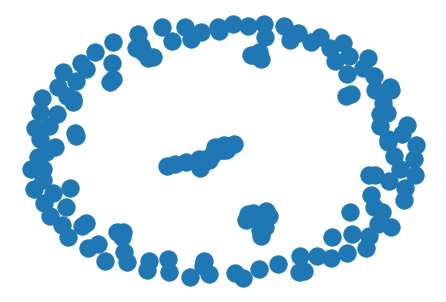

In [0]:

  
G = nx.Graph(mat3)
print(nx.number_connected_components(G))
print(G.number_of_nodes())
print(G.number_of_edges())
nx.draw(G)
plt.show()
  
  
